In [35]:
import numpy as np
from scipy.linalg import solve_banded
import matplotlib.pyplot as plt
import math
from decimal import Decimal, getcontext


************************************************************************
*
*     OTIS: One-dimensional Transport with Inflow and Storage
*     -------------------------------------------------------
*     
*     OTIS is a mathematical simulation model used to characterize the
*     fate and transport of water-borne solutes in streams and rivers.
*     The governing equation underlying the model is the advection-
*     dispersion equation with additional terms to account for transient
*     storage, lateral inflow, first-order decay and sorption. This
*     equation and the associated equations describing transient
*     storage and sorption are solved using a Crank-Nicolson finite
*     difference solution.
*
*     The OTIS solute transport model, data, and documentation are made
*     available by the U.S. Geological Survey (USGS) to be used in the
*     public interest and the advancement of science. You may, without
*     any fee or cost, use, copy, modify, or distribute this software,
*     and any derivative works thereof, and its supporting
*     documentation, SUBJECT TO the USGS software User's Rights Notice
*     (http://water.usgs.gov/software/software_notice.html)
*
*
************************************************************************
*
*     Version: MOD40         Feb. 1998
*
************************************************************************
*
*     Reference
*     ---------
*     Runkel, R.L., 1998, One dimensional transport with inflow and
*       storage (OTIS): A solute transport model for streams and rivers:
*       U.S. Geological Survey Water-Resources Investigation Report
*       98-4018. xx p.
*
*     Homepage:  http://webserver.cr.usgs.gov/otis/home.html
*     ---------
*
*     Author
*     ------
*     R.L. Runkel
*     U.S. Geological Survey
*     Mail Stop 415
*     Denver Federal Center
*     Lakewood, CO 80225
*     Internet: runkel@usgs.gov
*
************************************************************************
*
*                            SEGMENTATION
*
************************************************************************
*
*
*
*     |<--- Hi-1 --->|<---- Hi ---->|<--- Hi+1 --->|
*     ______________________________________________
*     |              |              |              |
*     |     Ci-1     |      Ci      |     Ci+1     |
*     |     Qi-1     |      Qi      |     Qi+1     | 
*     |     Ai-1     |      Ai      |     Ai+1     |
*     |              |              |              |              
*     ----------------------------------------------
*                  DFACEi         DFACEi+1
*                  AFACEi         AFACEi+1
*
*     where:
*
*           A = AREA
*           C = CONC, CONC2, or SORB
*           H = DELTAX
*
*     as defined below.
*
*
************************************************************************
*
*                      DICTIONARY - INPUT VARIABLES
*
************************************************************************
*
*     Required Input Data
*     -------------------
*     TITLE      simulation title
*     PRTOPT     print option
*     TSTEP      time step interval [hr]
*     PSTEP      print step interval [hr]
*     TSTART     starting time [hr]
*     TFINAL     final time [hr]
*     XSTART     starting distance at upstream boundary [L]
*     DSBOUND    downstream boundary condition (flux) [mass/L^2-s]
*     NREACH     number of reaches
*
*     Required Reach Parameters (One value for each reach)
*     ----------------------------------------------------
*     NSEG       number of segments
*     RCHLEN     length of reach [L]
*     DISP       dispersion coefficient [L^2/s]
*     AREA2      storage zone cross-sectional area [L^2]
*     ALPHA      exchange coefficient [/s]
*
*     Required Print Information
*     --------------------------
*     NPRINT     number of print locations
*     IOPT       interpolation option
*     PRTLOC     distance at which results are printed [L]
*
*     Required Chemical Information
*     -----------------------------
*     NSOLUTE    number of solutes to simulate
*     IDECAY     decay flag (=0 no decay; =1 first-order decay)
*     ISORB      sorption flag (=0 no sorption; =1 Kd sorption)
*
*     First-Order Decay Rate Information (Required for IDECAY=1)
*     ----------------------------------------------------------
*     LAMBDA     decay coefficient for the main channel [/s]
*     LAMBDA2    decay coefficient for the storage zone [/s]
*
*     Kd Sorption Information (Required for ISORB=1)
*     ----------------------------------------------
*     LAMHAT     sorption rate coefficient for the main channel [/sec]
*     LAMHAT2    sorption rate coefficient for the storage zone [/sec]
*     RHO        mass of accessibile sediment/volume water [mass/L^3]
*     KD         distribution coefficient [L^3/mass]
*     CSBACK     background storage zone solute concentration [mass/L^3]
*
*     Required Chemical and Upstream Boundary Condition Information
*     -------------------------------------------------------------
*     NBOUND     number of different upstream boundary conditions
*     IBOUND     boundary condition option
*     USTIME     time at which upstream boundary condition goes
*                into effect [hr]
*     USBC       upstream boundary condition
*
*     Required Flow and Area Information
*     ----------------------------------
*     QSTEP      time interval between changes in flow (0=steady flow)
*     QSTART     volumetric flowrate at upstream boundary [L^3/s]
*     QLATIN     lateral inflow rate [L^3/s-L]
*     QLATOUT    lateral outflow rate [L^3/s-L]
*     AREA       main channel cross-sectional area [L^2]
*     CLATIN     concentration of lateral inflow [mass/L^3]
*
*     Information for Unsteady Flow Regimes (QSTEP > 0)
*     -------------------------------------------------
*     NFLOW      number of locations at which Q and AREA are specified
*     FLOWLOC    distance at which Q and AREA are specified [L]
*     QVALUE     flowrates at specified distances
*     QINVAL     lateral inflow rate at specified distances
*     AVALUE     areas at specified distances
*     CLVAL      concentration of lateral inflows at specified distances
*
************************************************************************
*
*                      DICTIONARY - PROGRAM VARIABLES
*
************************************************************************
*
*     State Variables
*     ---------------
*     CONC       concentration in main channel [mass/L^3]
*     CONC2      concentration in storage zone [mass/L^3]
*     SORB       streambed sediment concentration [mass/mass]
*
*     System definition and hydrology
*     -------------------------------
*     AFACE      cross sectional area @ interface of segments I,I+1
*     DFACE      dispersion coefficient @ interface of segments I,I+1
*     DELTAX     segment length [L]
*     IMAX       number of segments
*     LASTSEG    last segment in each reach
*     DIST       distance corresponding to segment centroid
*     Q          volumetric flowrate [L^3/s]
*     QINDEX     flow location used for interpolation (when QSTEP > 0)
*     QWT        weight used to interpolate between QINDEX and QINDEX+1
*     DSDIST     distance to the nearest downstream flow location/DELTAX
*     USDIST     distance to the nearest upstream flow location / DELTAX 
*
*     Matrix Solution
*     ---------------
*     A          upper diagonal of the tridiagonal matrix
*     B          main diagonal of the tridiagonal matrix
*     C          lower diagonal of the tridiagonal matrix
*     D          constant vector
*     AWORK      work vector corresponding to A
*     BWORK      work vector corresponding to B
*
*     Parameter Groups - Time invariant (H = DELTAX)
*     ----------------------------------------------
*     HPLUSF     H(i) + H(i+1)
*     HPLUSB     H(i) + H(i-1)
*     HMULTF     H(i) [ H(i) + H(i+1) ]
*     HMULTB     H(i) [ H(i) + H(i-1) ]
*     HDIV       H(i) / [ H(i) + H(i+1) ]
*     HDIVF      H(i+1) / [ H(i) + H(i+1) ]
*     HADV       0.5/H(i) { H(i+1)/[H(i+1)+H(i)] - H(i-1)/[H(i-1)+H(i)]}
*     LAM2DT     storage zone decay coefficient times the timestep
*     LHATDT     main channel sorption rate times the timestep
*     LHAT2DT    storage zone sorption rate times the timestep
*     RHOLAM     mass of access. sediment times the m.c. sorption rate
*     SGROUP     sorption parameter group
*     SGROUP2    sorption parameter group
*
*     Parameter Groups - Time invariant given steady flow
*     ---------------------------------------------------
*     BN         group related to the main diagonal vector, B
*     BTERMS     group related to the main diagonal vector, B
*     GAMMA      group introduced by storage zone equation
*     IGROUP     inflow group 
*     TGROUP     transient storage group
*     TWOPLUS    2 + .....
*
*     Boundary Conditions & Flow Changes
*     ----------------------------------
*     BCSTOP     time at which the boundary conditions change
*     JBOUND     index of the current boundary condition
*     STOPTYPE   indicates whether the next TSTOP is due to a change
*                in the boundary conditions or the flow variables.
*     TSTOP      time at which the boundary condition or flow variables
*                change
*     USCONC     concentration at the upstream boundary
*     QSTOP      time at which the flow variables change
*
*     Program Variables - Misc.
*     -------------------------
*     TIMEB      inverse of the time step [/sec]
*     TIME       time [hr]
*     CHEM       type of chemistry considered (reactive or conservative)
*     IPRINT     number of iterations between printing of results
*     PINDEX     segments for which results are printed
*     WT         weight used to interpolate between PINDEX and PINDEX+1
*
*     Program Variables - time level 'N'
*     ----------------------------------
*     The following variables contain values of associated with the
*     previous timestep, time level 'N'.  Their counterparts at time
*     level 'N+1' are defined above:
*     
*     AFACEN,AN,AREAN,BTERMSN,CLATINN,CN,GAMMAN,QLATINN,QN,USCONCN
*
*     i.e. CLATINN is the lateral inflow concentration at time N, while
*     CLATIN is corresponding concentration at time N+1.
*
************************************************************************
*
*                      INCLUDE FILES
*
*************************************************************************
*   
*     Maximum Dimensions (set via PARAMETER statements in fmodules.inc)
*     -----------------------------------------------------------------
*     MAXSEG     maximum number of segments
*     MAXBOUND   maximum number of upstream boundary conditions
*     MAXREACH   maximum number of reaches
*     MAXPRINT   maximum number of print locations
*     MAXSOLUTE  maximum number of solutes
*     MAXFLOWLOC maximum number of flow locations (unsteady flow)
*
*     Logical Devices (as defined in lda.inc)
*     ---------------------------------------
*     LDCTRL     input control information (I/O filenames)
*     LDPARAM    input file for chemical and physical parameters
*     LDFLOW     input file for flow, lateral inflow, and areas
*     LDECHO     output data and time, echo input parameters
*     LDFILES    output files, one file per solute
*     LDSORB     sorption output files (ISORB=1), one file per solute
*
************************************************************************

In [3]:
C, C_s, C_sed = [], [], []

global imax
imax = 100

global time
time = 0.0


dx = 0.01
dt = 0.01

global nsolute, idecay, isorb, ibound, nbound, nprint, iopt


global q

nsolute, idecay, isorb = 0, 0, 0
ibound, nbound = 0, 0
nprint, iopt = 0, 0

prtloc = np.array([])
# nsolute = 2
# chem = 'Steady-State'
chem = 'Conservative'

alpha = np.zeros(imax)
area = np.zeros(imax)
area2 = np.zeros(imax)



# deltax = np.full(imax, dx)
disp = np.full(imax, 1.0)


In [4]:
def fill_segmented_array(reaches, imax, attribute_name, lastseg):
    """
    Fills an array with values from segmented parts of another array.

    Parameters:
    - reaches: A list of dictionaries containing segment data.
    - imax: The length of the output array.
    - attribute_name: The key to extract values from reaches.
    - lastseg: Indices representing the end of each segment in the output array.

    Returns:
    - filled_array: An array of length imax, filled with values from reaches
      according to segments defined by lastseg.
    """
    
    # Extract attribute values from reaches using list comprehension
    values = np.array([reach[attribute_name] for reach in reaches])
    
    # Initialize the output array with zeros
    filled_array = np.zeros(imax)
    
    # Keep track of the previous segment's end index, start with -1 for the first iteration
    prev_end = -1
    
    # Iterate over each segment end index to fill the output array segment-wise
    for i, end in enumerate(lastseg):
        # Fill the segment with the corresponding value
        # The slice starts from prev_end+1 to end (inclusive)
        filled_array[prev_end + 1:end + 1] = values[i]
        # Update prev_end for the next iteration
        prev_end = end
    
    return filled_array

def search_index(lines, keyword, start_index=0):
    """
    Search for a keyword in a list of strings starting from a specific index, and return the index of the first match.

    Parameters:
    - lines: A list of strings to search through.
    - keyword: The string to search for.
    - start_index: The index to start the search from.

    Returns:
    - index: The index of the first match after the start_index, or -1 if no match is found.
    """
    for i in range(start_index, len(lines)):
        if keyword in lines[i]:
            return i
    return -1


In [5]:
global ustime, usbc, prtloc
ustime, usbc = np.array([]), np.array([])

def read_parameters(file_path):
    # 初始化参数字典
    global nsolute, idecay, isorb, nbound, ibound, nprint, iopt  # 声明这些变量为全局变量
    global ustime, usbc, prtloc, imax
    lastseg = 0
    parameters = {}
    reaches, lams = [], []
    total_length = 0   
    with open(file_path, 'r') as file:
        lines = file.readlines()

    index = search_index(lines, 'TITLE')
    
    # 从指定的起始行开始读取主要模型参数
    for i in range(index, len(lines)):
        line = lines[i]
        if line.strip().startswith('###########################################################'):
            break  
        parts = line.split('|')
        if len(parts) == 2:
            key = parts[1].strip().split('[')[0].strip()  
            value = parts[0].strip()
            try:
                parameters[key] = float(value)
            except ValueError:
                parameters[key] = value
    
                
    index = search_index(lines, 'NSEG') + 3

    for i in range(index, len(lines)):
        line = lines[i]
        if line.strip().startswith('###########################################################'):
            break  
        parts = line.split()
        if len(parts) == 5:
            nseg, rchlen, disp, area2, alpha = map(float, parts)
            deltax = rchlen / nseg
            total_length += rchlen
            end = total_length
            lastseg += int(nseg)
            reach = {'NSEG': nseg, 
                         'RCHLEN': rchlen,
                         'DISP': disp, 
                         'AREA2': area2, 
                         'ALPHA': alpha,
                         'DELTAX': deltax,
                         'END': end,
                         'LASTSEG': lastseg}
            reaches.append(reach)

    # 计算总分段数
    imax = int(lastseg)
    
    index = search_index(lines, 'NSOLUTE') + 3
    for i in range(index, len(lines)):
        line = lines[i]
        parts = line.strip().split()
        nsolute, idecay, isorb = map(int, parts)
        break
    
    if idecay == 1:
        index = search_index(lines, 'LAMBDA') + 3
        for i in range(index, len(lines)):
            line = lines[i]
            parts = line.split()
            if len(parts) == 2:
                lambda1, lambda2 = map(float, parts)
                lam = {'LAMBDA': lambda1, 
                        'LAMBDA2': lambda2}
                lams.append(lam)            

    index = search_index(lines, 'IOPT')
    for i in range(index, len(lines)):
        line = lines[i]
        nprint = int(line[0:5].strip())
        iopt = int(line[5:10].strip())
        break
    
    index = search_index(lines, 'PRTLOC')
    for i in range(index, len(lines)):
        line = lines[i]
        if line.strip().startswith('###########################################################'):
            break  # reach参数结束的标志
        parts = line.split()
        if parts:
            prtloc = np.append(prtloc, float(parts[0]))

    index = search_index(lines, 'NBOUND')
    for i in range(index, len(lines)):
        line = lines[i]
        nbound = int(line[0:5].strip())
        ibound = int(line[5:10].strip())
        break
    
    index = search_index(lines, 'USTIME') + 3
    for i in range(index, len(lines)):
        line = lines[i]
        parts = line.strip().split()
        if len(parts) == 2:
            #print("parts:", parts)
            x1 = float(parts[0])
            x2 = float(parts[1])
            ustime = np.append(ustime, x1)
            usbc = np.append(usbc, x2)
            #print("x1:",x1, "x2",x2)
        else:
            continue

    usconc = np.zeros((imax, nsolute))

    for j in range(nsolute):
        for i in range(nbound):
            if ibound == 1 or ibound ==3:
                usconc[i,j] = usbc[i]
            elif ibound == 2:
                #usconc[i,j] = usbc[i]/qstart
                pass
    
    lastseg = np.array([reach["LASTSEG"] for reach in reaches]) - 1

    print(reaches)

    nseg = np.array([reach["NSEG"] for reach in reaches])
    rchlen = np.array([reach["RCHLEN"] for reach in reaches])
    #area2 = np.array([reach["AREA2"] for reach in reaches])
    #alpha = np.array([reach["ALPHA"] for reach in reaches])
    #deltax = np.array([reach["DELTAX"] for reach in reaches])
    end = np.array([reach["END"] for reach in reaches])

    lastseg = np.array([reach["LASTSEG"] for reach in reaches]) - 1
    disp = fill_segmented_array(reaches, imax, "DISP", lastseg)
    deltax = fill_segmented_array(reaches, imax, "DELTAX", lastseg)
    area2 = fill_segmented_array(reaches, imax, "AREA2", lastseg)
    alpha = fill_segmented_array(reaches, imax, "ALPHA", lastseg)
    lambda2, lambda_ = None, None
    if idecay == 1:
        lambda_ = fill_segmented_array(lams, imax, "LAMBDA", lastseg)
        lambda2 = fill_segmented_array(lams, imax, "LAMBDA2", lastseg)

    
    return lambda2, lambda_, usconc, lastseg, reaches, parameters, lines, nseg, rchlen, disp, area2, alpha, deltax, end

# 调用函数，传入参数文件的路径
lambda2, lambda_, usconc, lastseg, reaches, parameters, lines, nseg, rchlen, disp, area2, alpha, deltax, end = read_parameters('../examples/app1/params.inp')

usconcn = np.zeros(nsolute)

for j in range(nsolute):
    usconcn[j] = usconc[0,j]

global title, prtopt, pstep, tstep, tfinal, xstart, dsbound, nreach, imax, iprint
title = parameters['TITLE']
prtopt = parameters['PRTOPT']
pstep = parameters['PSTEP']
tstep = parameters['TSTEP']
tfinal = parameters['TFINAL']
xstart = parameters['XSTART']
dsbound = parameters['DSBOUND']
nreach = parameters['NREACH']
#lastseg = parameters['LASTSEG']
#imax = int(parameters['IMAX'])

if tstep != 0.0:
    iprint = round(pstep/tstep)
else:
    iprint = 0

if iprint < 1:
    iprint = 1

# 打印主要模型参数以确认
print("Main Model Parameters:")
for key, value in parameters.items():
    print(f"{key}: {value}")
# 打印每个reach的参数以确认
print("\nPhysical Parameters for Each Reach:")
for i, reach in enumerate(reaches, start=1):
    print(f"Reach {i}: {reach}")


[{'NSEG': 38.0, 'RCHLEN': 38.0, 'DISP': 0.12, 'AREA2': 0.05, 'ALPHA': 0.0, 'DELTAX': 1.0, 'END': 38.0, 'LASTSEG': 38}, {'NSEG': 67.0, 'RCHLEN': 67.0, 'DISP': 0.15, 'AREA2': 0.05, 'ALPHA': 0.0, 'DELTAX': 1.0, 'END': 105.0, 'LASTSEG': 105}, {'NSEG': 176.0, 'RCHLEN': 176.0, 'DISP': 0.24, 'AREA2': 0.36, 'ALPHA': 3e-05, 'DELTAX': 1.0, 'END': 281.0, 'LASTSEG': 281}, {'NSEG': 152.0, 'RCHLEN': 152.0, 'DISP': 0.31, 'AREA2': 0.41, 'ALPHA': 1e-05, 'DELTAX': 1.0, 'END': 433.0, 'LASTSEG': 433}, {'NSEG': 236.0, 'RCHLEN': 236.0, 'DISP': 0.4, 'AREA2': 1.56, 'ALPHA': 4.5e-05, 'DELTAX': 1.0, 'END': 669.0, 'LASTSEG': 669}]
Main Model Parameters:
TITLE: Bencala & Walters, Uvas Creek Chloride
PRTOPT: 2.0
PSTEP: 0.1
TSTEP: 0.05
TSTART: 8.25
TFINAL: 24.0
XSTART: 0.0
DSBOUND: 0.0
NREACH: 5.0

Physical Parameters for Each Reach:
Reach 1: {'NSEG': 38.0, 'RCHLEN': 38.0, 'DISP': 0.12, 'AREA2': 0.05, 'ALPHA': 0.0, 'DELTAX': 1.0, 'END': 38.0, 'LASTSEG': 38}
Reach 2: {'NSEG': 67.0, 'RCHLEN': 67.0, 'DISP': 0.15, 'ARE

In [6]:
def inputq(file_path, nsolute = 1):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    qstep = float(lines[12].strip().split()[0])
    qstart = float(lines[13].strip().split()[0])
    latins = []
    for line in lines[20:]:
        parts = line.strip().split()
        if len(parts) == 4:
            qlatin, qlatout, area, clatin = map(float, parts)
            latins.append({
                "QLATIN": qlatin,
                "QLATOUT": qlatout,
                "AREA": area,
                "CLATIN": clatin
            })

    #qlatin = np.array([latin["QLATIN"] for latin in latins])
    #qlatout = np.array([latin["QLATOUT"] for latin in latins])
    #area = np.array([latin["AREA"] for latin in latins])
    #clatin = np.array([latin["CLATIN"] for latin in latins])
    qlatin = fill_segmented_array(latins, imax, "QLATIN", lastseg)
    qlatout = fill_segmented_array(latins, imax, "QLATOUT", lastseg)
    area = fill_segmented_array(latins, imax, "AREA", lastseg)
    clatin = fill_segmented_array(latins, imax, "CLATIN", lastseg)

    for _ in range(nsolute):
        clatin = clatin[:,np.newaxis]

    return qstep, qstart, qlatin, qlatout, area, clatin

# flow initial
q = np.zeros(imax)

# qunsteady

nflow = imax
flowloc = np.zeros(imax, dtype=np.float64)
flowloc = np.array([dx * (i+1) for i, dx in enumerate(deltax)])

qstep, qstart, qlatin, qlatout, area, clatin = inputq('../examples/app1/q.inp')

if chem!= 'Steady-State':
    print("Unsteady-State Flow Set up")
    qvalue = q
    clval = clatin
    avalue = area
    qinval = qlatin
    qstart = qvalue[0]


Unsteady-State Flow Set up


In [7]:
def distance(imax, deltax, xstart):
    dist = np.zeros(imax)
    dist[0] = xstart + 0.5 * deltax[0]
    for i in range(1, imax):
        dist[i] = dist[i-1] + 0.5 * (deltax[i-1] + deltax[i])
    return dist

def weights():
    pindex = np.zeros(nprint, dtype=int)
    wt = np.zeros(nprint)
    prtloc = np.zeros(nprint)
    rprtloc = np.zeros(nprint)

    dist = distance(imax, deltax, xstart)

    for i in range(nprint):
        # Error check: print location exceeds the distance at the end of the stream
        if rprtloc[i] > dist[-1]:
            raise ValueError(f"Print location {rprtloc[i]} exceeds distance at end of stream {dist[-1]}")
        # Error check: print location is in the upstream half of the first segment
        if rprtloc[i] < dist[0]:
            print(f"WARNING: Print Location ({rprtloc[i]}) is less than distance of the first segment. Print location set to {dist[0]}")
            rprtloc[i] = dist[0]

        # Find the appropriate segment
        for j in range(imax - 1):
            if dist[j] <= rprtloc[i] <= dist[j + 1]:
                pindex[i] = j
                if iopt == 1:  # Interpolation requested
                    wt[i] = (rprtloc[i] - dist[j]) / (dist[j + 1] - dist[j])
                    prtloc[i] = rprtloc[i]
                else:  # Nearest upstream segment
                    if rprtloc[i] == dist[j + 1]:
                        wt[i] = 1.0
                        prtloc[i] = rprtloc[i]
                    else:
                        wt[i] = 0.0
                        prtloc[i] = dist[j]
                break
    return pindex, wt, prtloc, rprtloc, dist

pindex, wt, prtloc, rprtloc, dist = weights()
print(pindex, wt, prtloc, rprtloc)

[0 0 0 0 0] [0. 0. 0. 0. 0.] [0.5 0.5 0.5 0.5 0.5] [0.5 0.5 0.5 0.5 0.5]


In [8]:
def flow_init():
    global q
    q[0] = qstart + 0.5 * deltax[0] * (qlatin[0] - qlatout[0])
    print("q0 is ", q[0])
    for i in range(1, imax):
        q[i] = q[i-1] + 0.5 * (
            (qlatin[i-1] - qlatout[i-1]) * deltax[i-1] +
            (qlatin[i] - qlatout[i]) * deltax[i]
        )
    return q

def qweights(dist, flowloc, nflow):
    qwt = np.zeros(imax)
    qindex = np.zeros(imax)
    dsdist = np.zeros(imax)
    usdist = np.zeros(imax)
    if flowloc[0] != xstart:
        print("error2 @", flowloc[0])
    if flowloc[-1] < dist[imax-1]:
        print("error3 @", flowloc[-1], dist[imax-1])
    
    j = 2
    for i in range(imax):
        while dist[i] >= flowloc[j] and j < nflow - 1:  # Adjust loop control for Python indexing
            j += 1

        qwt[i] = (dist[i] - flowloc[j-1]) / (flowloc[j] - flowloc[j-1])
        qindex[i] = j
        dsdist[i] = (flowloc[j] - dist[i]) / deltax[i]
        usdist[i] = (dist[i] - flowloc[j-1]) / deltax[i]

    return qwt, qindex, dsdist, usdist

def wtavg(qdist, usval, dsval):
    return (0.5 - qdist) * usval + (0.5 + qdist) * dsval


def qainit(area, qvalue, avalue, qwt, qindex, qinval, clval, qlatin, clatin, dsdist, usdist, nsolute):
    global q
    # Initialize flow rates and areas
    for i in range(imax):  # Adjusted for 0-based indexing
        j = qindex[i] - 1  # Adjusted for 0-based indexing
        q[i] = qvalue[j - 1] + qwt[i] * (qvalue[j] - qvalue[j - 1])
        area[i] = avalue[j - 1] + qwt[i] * (avalue[j] - avalue[j - 1])

    # Set lateral flows and inflow concentrations
    for i in range(imax):  # Adjusted for 0-based indexing
        if usdist[i] < 0.5:
            # A flow location is within the upstream half of the segment
            qlatin[i] = wtavg(usdist[i], qinval[qindex[i] - 2], qinval[qindex[i] - 1])
            for j in range(nsolute):
                clatin[i, j] = wtavg(usdist[i], clval[qindex[i] - 2, j], clval[qindex[i] - 1, j])
        elif dsdist[i] < 0.5:
            # A flow location is within the downstream half of the segment
            qlatin[i] = wtavg(dsdist[i], qinval[qindex[i]], qinval[qindex[i] - 1])
            for j in range(nsolute):
                clatin[i, j] = wtavg(dsdist[i], clval[qindex[i], j], clval[qindex[i] - 1, j])
        else:
            qlatin[i] = qinval[qindex[i] - 1]
            for j in range(nsolute):
                clatin[i, j] = clval[qindex[i] - 1, j]
    
        return q, area, qlatin, clatin
    return

if qstep == 0:
    q = flow_init()
    print("Steady-State Q")
else:
    qwt, qindex, dsdist, usdist = qweights(dist, flowloc, nflow)
    q, area, qlatin, clatin = qainit(area, qvalue, avalue, qwt, qindex, qinval, clval, qlatin, clatin, dsdist, usdist, nsolute)
    print("Unsteady-State Q")


q0 is  0.5
Steady-State Q


In [9]:
def solveTridiagonalMatrix(lower_diag, main_diag, upper_diag, rhs_vector):
    # Convert lists to numpy arrays for manipulation
    lower_diag = np.array(lower_diag)
    main_diag = np.array(main_diag)
    upper_diag = np.array(upper_diag)
    rhs_vector = np.array(rhs_vector)
    
    # Create the banded matrix format for solve_banded function
    # The first row is one element shorter at the beginning, so prepend a zero
    upper_diag_shifted = np.hstack([0, upper_diag[:-1]])
    # The last row is one element shorter at the end, so append a zero
    lower_diag_shifted = np.hstack([lower_diag[1:], 0])
    # Combine into the matrix expected by solve_banded
    ab = np.vstack([upper_diag_shifted, main_diag, lower_diag_shifted])
    
    # Solve the tridiagonal matrix equation Ax = b for x
    solution_vector = solve_banded((1, 1), ab, rhs_vector)
    
    print("Solution x:", solution_vector)
    
    return solution_vector


In [10]:
def matrix(conc, a, b, c, d, j):
    # Ensure arrays are of double precision
    conc = np.array(conc, dtype=np.float64)
    a_work = np.zeros_like(a, dtype=np.float64)
    
    # Thomas algorithm for forward elimination
    for i in range(1, imax):
        a_work[i] = a[i] / b[i-1]
        b[i] = b[i] - a_work[i] * c[i-1]
        d[i] = d[i] - a_work[i] * d[i-1]
    print("a_work[imax-1]:", a_work[imax-2])
    print("b[imax-1]:", b[imax-2])
    print("d[imax-1]:", d[imax-2])
    print("c[imax-1]:", c[imax-2])
    print("conc[imax-1, j]:", conc[imax-2, j])
    # Back substitution
    conc[imax-1, j] = d[imax-1] / b[imax-1]
    for i in range(imax-2, -1, -1):
        conc[i, j] = (d[i] - c[i] * conc[i+1, j]) / b[i]
    
    return conc, b, d

def decomp(imax, a, b, c, j):
    a_work = np.zeros((imax, nsolute))
    b_work = np.zeros((imax, nsolute))

    b_work[0, j] = b[0, j]

    for i in range(1, imax):
        a_work[i, j] = a[i] / b_work[i-1, j]
        b_work[i, j] = b[i, j] - a_work[i, j] * c[i-1]

    return a_work, b_work

In [11]:
def setstop(qstop, bcstop, ibound):
    """
    Determine the endpoint of the integration, TSTOP, based on boundary condition or flow variables change.
    
    Parameters:
    - qstop: The time at which flow changes.
    - bcstop: The time at which the boundary condition changes.
    - ibound: Type of the boundary condition.
    
    Returns:
    - tstop: The determined stopping point for the integration.
    - stoptype: The type of change causing the stopping ('Both', 'QChange', or 'BCondition').
    """
    
    # For a continuous boundary condition (IBOUND=3), force a boundary condition change for every change in the flow.
    if ibound == 3 and qstop < bcstop:
        bcstop = qstop

    # Determine the stopping point and type
    if abs(qstop - bcstop) < 1e-7:  # Comparing floating point numbers for equality
        tstop = qstop
        stoptype = 'Both'
    elif qstop < bcstop:
        tstop = qstop
        stoptype = 'QChange'
    else:  # BCSTOP < QSTOP
        tstop = bcstop
        stoptype = 'BCondition'

    return tstop, stoptype

In [12]:
# Initialize arrays
dface = np.zeros(imax)
hplusf = np.zeros(imax)
hplusb = np.zeros(imax)
hmultf = np.zeros(imax)
hmultb = np.zeros(imax)
hdiv = np.zeros(imax)
hdivf = np.zeros(imax)
hadv = np.zeros(imax)

lambda_ = np.zeros((imax, nsolute))
lamhat = np.zeros((imax, nsolute))
lambda2 = np.zeros((imax, nsolute))
lamhat2 = np.zeros((imax, nsolute))
lhat2dt = np.zeros((imax, nsolute))

aface = np.zeros(imax)

conc = np.zeros((imax, nsolute))
conc2 = np.zeros((imax, nsolute))
sorb = np.zeros((imax, nsolute))
csback = np.zeros((imax, nsolute))
kd = np.zeros((imax, nsolute))
rholam = np.zeros((imax, nsolute))

lam2dt = np.zeros((imax, nsolute))
sgroup = np.zeros((imax, nsolute))
sgroup2 = np.zeros((imax, nsolute))

def preproc1(disp, deltax):

    # Compute the interfacial dispersion coefficient
    dface[:-1] = (deltax[:-1] / (deltax[1:] + deltax[:-1]) * disp[1:] +
                  deltax[1:] / (deltax[1:] + deltax[:-1]) * disp[:-1])
    dface[-1] = disp[-1]

    # Compute the H-groups for the first segment
    hplusf[0] = deltax[0] + deltax[1]
    hmultf[0] = deltax[0] * hplusf[0]
    hdiv[0] = deltax[0] / hplusf[0]
    hdivf[0] = deltax[1] / hplusf[0]

    # Compute the H-groups for segments 2 through IMAX-1
    hplusf[1:-1] = deltax[1:-1] + deltax[2:]
    hplusb[1:] = deltax[1:] + deltax[:-1]
    hmultf[1:-1] = deltax[1:-1] * hplusf[1:-1]
    hmultb[1:] = deltax[1:] * hplusb[1:]
    hdiv[1:-1] = deltax[1:-1] / hplusf[1:-1]
    hdivf[1:-1] = deltax[2:] / hplusf[1:-1]
    hadv[1:-1] = 0.5 * (hdivf[1:-1] - deltax[:-2] / hplusb[1:-1]) / deltax[1:-1]

    # Compute the H-groups for the last segment
    # Note: hplusb, hmultb for the last segment already computed

def preproc2(lambda2, lamhat, lamhat2, rholam, csback, timeb, imax):
    global nsolute
    lhatdt = np.zeros((imax, nsolute))
    lhat2dt = np.zeros((imax, nsolute))
    sgroup = np.zeros((imax, nsolute))
    sgroup2 = np.zeros((imax, nsolute))
    lam2dt = np.zeros((imax, nsolute))
    
    for i in range(imax):
        for j in range(nsolute):
            lam2dt[i, j] = lambda2[i, j] / timeb
            lhatdt[i, j] = lamhat[i, j] / timeb
            lhat2dt[i, j] = lamhat2[i, j] / timeb
            sgroup[i, j] = rholam[i, j] / (2.0 + lhatdt[i, j])
            sgroup2[i, j] = lhat2dt[i, j] * csback[i, j]

    return lam2dt, lhatdt, lhat2dt, sgroup, sgroup2

def preproc3(aface, timeb, gamman=None, btermsn=None, qlatinn=None, clatinn=None, arean=None ):
    global nsolute
    
    a = np.zeros(imax,dtype=np.float64)
    b = np.zeros((imax, nsolute))
    c = np.zeros(imax,dtype=np.float64)
    gamma = np.zeros(imax,dtype=np.float64)
    transb = np.zeros(imax,dtype=np.float64)
    twoplus = np.zeros((imax, nsolute))
    bterms = np.zeros((imax, nsolute))
    btermsn = np.zeros((imax, nsolute))
    bn = np.zeros((imax, nsolute))
    igroup = np.zeros((imax, nsolute))


    if gamman is None:
        gamman = gamma
    if btermsn is None:
        btermsn = bterms
    if qlatinn is None:
        qlatinn = qlatin
    if clatinn is None:
        clatinn = clatin
    if arean is None:
        arean = area

    # strob = np.zeros(imax,dtype=np.float64)

    aface[0] = hdiv[0] * area[1] + hdivf[0] * area[0]
    
    # Set coefficients for segment 1
    a[0] = 0.0
    advb = 0.5 * q[0] * hdivf[0] / (area[0] * deltax[0])
    advc = 0.5 * q[0] / (area[0] * hplusf[0])
    ad = np.zeros(imax + 1)
    ad[0] = aface[0] * dface[0]
    ad[1] = ad[0]  # Adjusting for Python's indexing
    dispb = (ad[1]/hplusf[0] + ad[0]/deltax[0]) / (area[0]*deltax[0])
    dispc = -ad[1] / (area[0] * hmultf[0])
    latb = qlatin[0] / (2 * area[0])
    gamma[0] = area[0] * alpha[0] / (timeb * area2[0])
    transb[0] = advb + dispb + latb
    c[0] = advc + dispc

    # Loop for segments 2 through IMAX-1
    for i in range(1, imax - 1):
        aface[i] = hdiv[i] * area[i + 1] + hdivf[i] * area[i]
        adva = -0.5 * q[i] / (area[i] * hplusb[i])
        advb = hadv[i] * q[i] / area[i]
        advc = 0.5 * q[i] / (area[i] * hplusf[i])

        ad[i] = aface[i] * dface[i]
        dispa = -ad[i - 1] / (area[i] * hmultb[i])
        dispb = (ad[i]/hplusf[i] + ad[i - 1]/hplusb[i]) / (area[i] * deltax[i])
        dispc = -ad[i] / (area[i] * hmultf[i])

        latb = qlatin[i] / (area[i] * area[i])
        gamma[i] = area[i] * alpha[i] / (timeb * area2[i])
        transb[i] = advb + dispb + latb
       
        a[i] = adva + dispa
        c[i] = advc + dispc

    # Set coefficients for the last segment
    i = imax - 1  # Adjusting for Python's 0-based indexing
    c[i] = 0.0
    aface[i] = area[i]
    adva = -0.5 * q[i] / (area[i] * hplusb[i])
    advb = -adva
    dispa = -ad[i - 1] / (area[i] * hmultb[i])
    dispb = -dispa
    latb = qlatin[i] / (2 * area[i])
    gamma[i] = area[i] * alpha[i] / (timeb * area2[i])
    transb[i]= advb + dispb + latb
    a[i] = adva + dispa

    for j in range(nsolute):
        for i in range(imax):
            twoplus[i, j] = 2.0 + gamma[i] + lam2dt[i, j] + lhat2dt[i, j]
            strob = 0.5 * alpha[i] * (1.0 - gamma[i] / twoplus[i, j])
            decayb = 0.5 * lambda_[i, j]
            sorbb = sgroup[i, j] + kd[i, j]
            bterms[i, j] = transb[i] + decayb + sorbb
            b[i, j] = timeb + bterms[i, j] + strob

            bn[i, j] = timeb - btermsn[i, j] - 0.5  * alpha[i] * (1.0 - gamman[i] / twoplus[i, j])
            igroup[i, j] = 0.5 * alpha[i] * (4.0 + gamma[i] - gamman[i]) / twoplus[i, j]
            igroup[i, j] = 0.5 * (qlatin[i] * clatinn[i, j] / arean[i] + qlatin[i]*clatin[i, j]/area[i])
    
        a_work, b_work = decomp(imax, a, b, c, j)

    return a_work, b_work, a, b, c, gamma, twoplus, bterms


In [13]:
def preproc(ustime, tstep, ibound, qstep, disp, deltax, lamhat, lamhat2):
    tstart = 0
    # Compute the inverse of the time step
    if chem != 'Steady-State':
        timeb = 1.0 / (tstep * 3600.0)
        print("timeb:", timeb)
    else:
        timeb = None
        print("NO timeb")

    # Initialize the upstream boundary condition variables
    np.append(ustime,99999.99)  # Assume ustime is a list and can be appended
    jbound = 0
    if ibound in [1, 2]:
        bcstop = ustime[jbound]
    elif ibound == 3:
        bcstop = tstart

    # Initialize the time at which a change in flow occurs
    if qstep == 0.0:
        qstop = 99999.99
    else:
        qstop = tstart + qstep

    # Preprocessing steps
    preproc1(disp, deltax)
    if chem != 'Steady-State':
        print("Process preproc2 and preproc3")
        lam2dt, lhatdt, lhat2dt, sgroup, sgroup2 = preproc2(lambda2, lamhat, lamhat2, rholam, csback, timeb, imax)
        a_work, b_work, a, b, c, gamma, twoplus, bterms = preproc3(aface, timeb)

    # Determine TSTOP
    print("Set stop")
    tstop, stoptype = setstop(qstop, bcstop, ibound)

    return timeb, a_work, b_work, a, b, c, gamma, twoplus, bterms, tstop, stoptype, bcstop, qstop, jbound, lam2dt, lhatdt, lhat2dt, sgroup, sgroup2

timeb, a_work, b_work, a, b, c, gamma, twoplus, bterms, tstop, stoptype, bcstop, qstop, jbound, lam2dt, lhatdt, lhat2dt, sgroup, sgroup2 = preproc(ustime, tstep, ibound, qstep, disp, deltax, lamhat, lamhat2)

timeb: 0.005555555555555556
Process preproc2 and preproc3
Set stop


In [14]:
def saven(a, c, gamma, bterms, timeb, twoplus):
    global nsolute
    an = np.zeros(imax)
    arean = np.zeros(imax)
    cn = np.zeros(imax)
    gamman = np.zeros(imax)
    qlatinn = np.zeros(imax)
    btermsn = np.zeros((imax, nsolute))
    clatinn = np.zeros((imax, nsolute))
    bn = np.zeros((imax, nsolute))
    tgroup = np.zeros((imax, nsolute))
    igroup = np.zeros((imax, nsolute))
    qn = np.zeros(imax)
    afacen = np.zeros(imax)

    for i in range(imax):
        an[i] = a[i]
        arean[i] = area[i]
        cn[i] = c[i]
        gamman[i] = gamma[i]
        qlatinn[i] = qlatin[i]
        for j in range(nsolute):
            btermsn[i, j] = bterms[i, j]
            clatinn[i, j] = clatin[i, j]
            bn[i, j] = timeb - btermsn[i, j] - 0.5 * alpha[i] * (1.0 - gamman[i]/twoplus[i, j])
            tgroup[i, j] = 0.5 * alpha[i] * (4.0 + gamma[i] - gamman[i]) / twoplus[i, j]
            igroup[i, j] = 0.5 * (qlatin[i] * clatinn[i, j] / arean[i] + qlatin[i] * clatin[i, j] / area[i])
    
    qn[0] = q[0]
    qn[1] = q[imax-1]
    afacen[0] = aface[0]
    afacen[1] = aface[imax-1]

    return an, arean, cn, gamman, qlatinn, btermsn, clatinn, bn, tgroup, igroup, qn, afacen

if chem!= 'Steady-State':
    print("Process saven")
    an, arean, cn, gamman, qlatinn, btermsn, clatinn, bn, tgroup, igroup, qn, afacen = saven(a, c, gamma, bterms, timeb, twoplus)
    

Process saven


In [15]:
def ssdiff(aface, q, hdiv,area,hdivf,deltax,usconc,hplusf,
    hmultf,dface,qlatin,clatin,lambda_,lamhat2,lambda2,
    csback,alpha,area2,conc):
    global imax, nsolute

    # aface = np.zeros(imax)
    areadisp = np.zeros(imax + 1)
    a = np.zeros(imax,dtype=np.float64)
    b = np.zeros(imax,dtype=np.float64)
    c = np.zeros(imax,dtype=np.float64)
    d = np.zeros(imax,dtype=np.float64)
    
    for j in range(nsolute):
        aface[0] = hdiv[0] * area[1] + hdivf[0] * area[0]
        
        a[0] = 0.0
        b[0] = q[0] * hdivf[0] / (area[0] * deltax[0])
        c[0] = q[0] / (area[0] * hplusf[0])
        d[0] = q[0] * usconc[0, j] / (area[0] * deltax[0])
        
        areadisp[0] = aface[0] * dface[0]
        areadisp[1] = areadisp[0]
        
        b[0] += 2.0 * (areadisp[1]/hplusf[0] + areadisp[0]/deltax[0]) / (area[0] * deltax[0])
        c[0] -= 2.0 * areadisp[1] / (area[0] * hmultf[0])
        d[0] += 2.0 * areadisp[0] * usconc[0, j] / (area[0] * deltax[0]**2)
        
        b[0] += qlatin[0] / area[0]
        d[0] += qlatin[0] * clatin[0, j] / area[0]

        #print("alpha[0]:", alpha[0])
        #print("area2[0]:", area2[0])
        #print("a[0]:", a[0])   
        #print("b[0]:", b[0])
        #print("c[0]:", c[0])
        #print("d[0]:", d[0])
        #print("lambda_[0, j]:", lambda_[0, j])
        
        if alpha[0] != 0.0:
            b[0] += alpha[0] * area2[0] * (lambda2[0, j] + lamhat2[0, j]) / (alpha[0] * area[0] + area2[0] * (lambda2[0, j] + lamhat2[0, j]))
            d[0] += alpha[0] * area2[0] * lamhat2[0, j] * csback[0, j] / (alpha[0] * area[0] + area2[0] * (lambda2[0, j] + lamhat2[0, j]))
        
        b[0] += lambda_[0, j]
        
        for i in range(1, imax - 1):
            aface[i] = hdiv[i] * area[i + 1] + hdivf[i] * area[i]
            
            a[i] = -q[i] / (area[i] * hplusb[i])
            b[i] = q[i] * 2.0 * hadv[i] / area[i]
            c[i] = q[i] / (area[i] * hplusf[i])
            d[i] = 0.0
            
            areadisp[i] = aface[i] * dface[i]
            a[i] -= 2.0 * areadisp[i - 1] / (area[i] * hmultb[i])
            b[i] += 2.0 * (areadisp[i]/hplusf[i] + areadisp[i - 1]/hplusb[i]) / (area[i] * deltax[i])
            c[i] -= 2.0 * areadisp[i] / (area[i] * hmultf[i])
            
            b[i] += qlatin[i] / area[i]
            d[i] += qlatin[i] * clatin[i, j] / area[i]
            
            if alpha[i] != 0.0:
                b[i] += alpha[i] * area2[i] * (lambda2[i, j] + lamhat2[i, j]) / (alpha[i] * area[i] + area2[i] * (lambda2[i, j] + lamhat2[i, j]))
                d[i] += alpha[i] * area2[i] * lamhat2[i, j] * csback[i, j] / (alpha[i] * area[i] + area2[i] * (lambda2[i, j] + lamhat2[i, j]))
            
            b[i] += lambda_[i, j]
        
        max = imax - 1
        c[max] = 0
        aface[max] = area[max]
        a[max] = -q[max] / (area[max] * hplusb[max])
        b[max] = q[max] * (1 - deltax[max - 1]/hplusb[max]) / (area[max] * deltax[max])
        d[max] = -q[max] * dsbound / (2 * area[max] * dface[max])
        
        a[max] += -2 * areadisp[max - 1] / (area[max] * hmultb[max])
        b[max] += 2 * areadisp[max - 1] / (area[max] * hmultb[max])
        d[max] += aface[max] * dsbound / (area[max] * deltax[max])

        b[max] += qlatin[max] / area[max]
        d[max] += qlatin[max] * clatin[max, j] / area[max]

        if alpha[max] != 0.0:
            b[max] += alpha[max] * area2[max] * (lambda2[max, j] 
                + lamhat2[max, j]) / (alpha[max] * area[max] 
                + area2[max] * (lambda2[max, j] + lamhat2[max, j]))
            
            d[max] += alpha[max] * area2[max] * lamhat2[max, j] * csback[max, j] / (alpha[max] * area[max] 
                + area2[max] * (lambda2[max, j] + lamhat2[max, j]))
            
        b[max] += lambda_[max, j]
        
        #print("alpha[i]:", alpha[i])
        #print("a",a)
        #print("b",b)
        #print("c",c)
        #print("d",d)
        #print("j:", j)
        
        conc, tempb, tempd = matrix(conc,a,b,c,d,j)

    return conc, tempd, tempb


In [16]:
def ssconc(conc, conc2, alpha, area, area2, lambda2, lamhat2, csback, kd, sorb):

    global nsolute,imax
    
    # 遍历每个溶质
    for j in range(nsolute):  # 注意：Python索引从0开始
        # 遍历每个段
        for i in range(imax):  # 注意：Python索引从0开始
            # 如果交换系数不为零，或者lamhat2不为零
            if alpha[i] != 0.0 or lamhat2[i, j] != 0.0:
                conc2[i, j] = (alpha[i] * area[i] * conc[i, j] + 
                               area2[i] * lamhat2[i, j] * csback[i, j]) / \
                              (alpha[i] * area[i] + 
                               area2[i] * (lambda2[i, j] + lamhat2[i, j]))
            else:
                conc2[i, j] = 0.0
            # 计算吸附物浓度
            sorb[i, j] = kd[i, j] * conc[i, j]

    return conc2, sorb

# 示例用法
# 假设imax, conc, alpha, area, area2, lambda2, nsolute, lamhat2, csback, kd已经定义并且初始化
# conc2 和 sorb 也应该被初始化为适当大小的数组
# ssconc(imax, conc, conc2, alpha, area, area2, lambda2, nsolute, lamhat2, csback, kd, sorb)

In [17]:
# print(type(usconc),usconc)
def steady(aface, q, hdiv,area,hdivf,deltax,usconc,hplusf,
    hmultf,dface,qlatin,clatin,lambda_,lamhat2,lambda2,
    csback,alpha,area2,conc, conc2, kd, sorb):
    print("Process ssdiff")
    #print("conc is ",conc)
    
    conc, tempd, tempb = ssdiff(aface, q, hdiv,area,hdivf,deltax,usconc,hplusf,
    hmultf,dface,qlatin,clatin,lambda_,lamhat2,lambda2,
    csback,alpha,area2,conc)

    #print("conc is ",conc)
    # 调用函数
    #conc2,sorb = ssconc(conc, conc2, alpha, area, area2, lambda2, lamhat2, csback, kd, sorb)
    return conc, conc2, sorb, tempb, tempd

conc, conc2, sorb, tempb, tempd = steady(aface, q, hdiv,area,hdivf,deltax,usconc,hplusf,
    hmultf,dface,qlatin,clatin,lambda_,lamhat2,lambda2,
    csback,alpha,area2,conc, conc2, kd, sorb)

if chem!= 'Steady-State':
    print("Initialization Done")

Process ssdiff
a_work[imax-1]: -1.000002643825353
b[imax-1]: 36.94010182525754
d[imax-1]: 270.396392327264
c[imax-1]: 36.14000420913438
conc[imax-1, j]: 0.0
Initialization Done


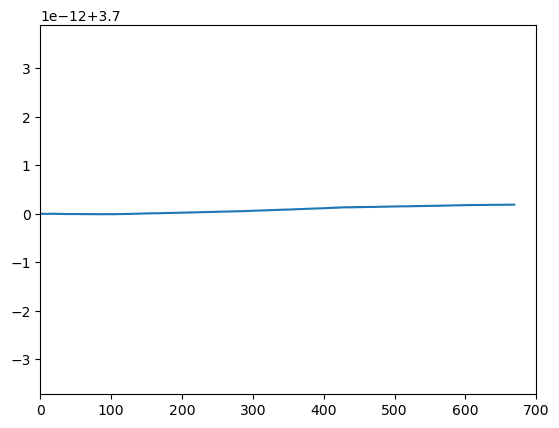

In [18]:
fig = plt.figure()


x_axis = np.array([dx * (i+1) for i, dx in enumerate(deltax)])

plt.plot(x_axis, conc[:,0])

plt.xlim(0,700)

plt.show()

In [19]:
"""
*     Subroutine QCHANGE             Called by: UPDATE
*
*     Read in the new flow variables, initialize the vectors, determine
*     the next time the flow changes, and set the concentration at the
*     upstream boundary.
"""

def qchange(q, area, qvalue, avalue, qwt, qindex, qinval, clval, qlatin, clatin, dsdist, usdist, nsolute):
    
    # qvalue, avalue, clval, qinval = readq(imax)
    q, area, qlatin, clatin = qainit(imax, q, area, qvalue, avalue, qwt, qindex, qinval, clval, qlatin, clatin, dsdist, usdist, nsolute)

    # Determine the next time the flow changes
    qstop = tstop + qstep

    # If a flux boundary condition is in effect, update the concentration at the upstream boundary based on the new flowrate
    if ibound == 2:
        for j in range(1, nsolute + 1):  # Adjust loop to start from 1 to nsolute inclusive
            for i in range(jbound, nbound + 1):  # Adjust loop to cover jbound to nbound inclusive
                usconc[i-1, j-1] = usbc[i-1, j-1] / qvalue[0]  # Adjust indices for 0-based indexing

    return qvalue, avalue, clval, qinval, q, area, qlatin, clatin, qstop


In [20]:
    
def yinterp(x, x1, x2, y1, y2):
    return y1 + (x - x1) * (y2 - y1) / (x2 - x1)
                                        
def bcchange(jbound, time, tstop, ibound, usconc, ustime, usbc, nsolute):
    # Check if the boundary condition is of type step
    if ibound == 1 or ibound == 2:
        #jbound += 1
        bcstop = ustime[jbound]  # Adjusted for 0-based indexing
    else:
        # Continuous boundary condition
        while time > ustime[jbound + 1]:  # Adjusted for 0-based indexing
            #jbound += 1
            pass
        for j in range(nsolute):  # Adjusted for 0-based indexing
            # Interpolate the boundary condition for the current time step
            usconc[jbound, j] = yinterp(time, ustime[jbound], ustime[jbound + 1],
                                        usbc[jbound, j], usbc[jbound + 1, j])
        bcstop = tstop + tstep

    return jbound, bcstop, usconc, bcstop

In [21]:
"""
*     Implement a change in the boundary conditions and/or the flow
*     variables.  This routine is called when:
*
*        (TIME - TSTEP)  =   TSTOP
*
*     where:
*
*        TSTOP           time of change
*        TIME            new time (time level N+1)
*        (TIME-TSTEP)    old time (time level N)
*
*     UPDATE the appropriate variables and reset TSTOP. 
"""

def update(jbound, q, stoptype, area, qvalue, avalue, qinval, clval, qlatin, clatin, nsolute, tstop, usconc, qstop):
    result = {}
    if stoptype == 'QChange':
        print("Process qchange")
        qvalue, avalue, clval, qinval, q, area, qlatin, clatin, qstop = qchange(q, area, qvalue, avalue, qindex, qinval, clval, qlatin, clatin, dsdist, usdist, nsolute)
        print("Process preproc3")
        a_work, b_work, a, b, c, gamma, twoplus, bterms = preproc3(aface, timeb)

        print("Set stop")
        tstop, stoptype = setstop(qstop, bcstop, ibound)

        #return qvalue, avalue, clval, qinval, q, area, qlatin, clatin, qstop, a_work, b_work, a, b, c, gamma, twoplus, bterms, tstop, stoptype
        result = {'qvalue': qvalue, 'avalue': avalue, 'clval': clval, 'qinval': qinval, 'q': q, 'area': area, 'qlatin': qlatin, \
                  'clatin': clatin, 'qstop': qstop, 'a_work': a_work, 'b_work': b_work, 'a': a, 'b': b, 'c': c, 'gamma': gamma, \
                    'twoplus': twoplus, 'bterms': bterms, 'tstop': tstop, 'stoptype': stoptype}
        
    elif stoptype == 'BCondition':

        # print("Process bcchange")
        jbound, bcstop, usconc, bcstop = bcchange(jbound, time, tstop, ibound, usconc, ustime, usbc, nsolute)
        
        # print("Set stop")
        tstop, stoptype = setstop(qstop, bcstop, ibound)

        #return jbound, bcstop, usconc, bcstop, tstop, stoptype
        result = {'jbound': jbound, 'bcstop': bcstop, 'usconc': usconc, 'tstop': tstop, 'stoptype': stoptype}

    else:
        print("Process qchange and bcchange")
        qvalue, avalue, clval, qinval, q, area, qlatin, clatin, qstop = qchange(q, area, qvalue, avalue, qindex, qinval, clval, qlatin, clatin, dsdist, usdist, nsolute)
        a_work, b_work, a, b, c, gamma, twoplus, bterms = preproc3(aface, timeb)
        jbound, bcstop, usconc, bcstop = bcchange(jbound, time, tstop, ibound, usconc, ustime, usbc, nsolute)

        tstop, stoptype = setstop(qstop, bcstop, ibound)

        # Return Wait Update 03222024
        result = {'qvalue': qvalue, 'avalue': avalue, 'clval': clval, 'qinval': qinval, 'q': q, 'area': area, 'qlatin': qlatin, \
                  'clatin': clatin, 'qstop': qstop, 'a_work': a_work, 'b_work': b_work, 'a': a, 'b': b, 'c': c, 'gamma': gamma, \
                    'twoplus': twoplus, 'bterms': bterms, 'tstop': tstop, 'stoptype': stoptype}
        
    
    return result
    


In [22]:
def substit(conc, awork, bwork, d, j):

    # Forward substitution
    for i in range(1, imax):  # Adjusted for 0-based indexing
        d[i] = d[i] - awork[i, j] * d[i - 1]

    # Backward substitution
    conc[imax - 1, j] = d[imax - 1] / bwork[imax - 1, j]
    for i in range(imax - 2, -1, -1):  # Adjusted for 0-based indexing and inclusive of the end point
        conc[i, j] = (d[i] - c[i] * conc[i + 1, j]) / bwork[i, j]
    
    return conc

In [39]:
def conser(usconcn, deltax, arean, area, cn, bn, tgroup, conc, aface, awork, bwork):
    oldconc = np.zeros(imax)
    d = np.zeros(imax)
    for j in range(nsolute):
        oldconc[0] = conc[0, j]
        d[0] = bn[0, 0] * conc[0, j] - cn[0] * conc[1, j] \
                + tgroup[0, 0] * conc2[0, j] \
                + igroup[0, j] \
                + 0.5 * (qn[0] * usconcn[j] / (arean[0] * deltax[0]) + q[0] * usconc[jbound, j] / (area[0] * deltax[0])) \
                + dface[0] * (afacen[0] * usconcn[j] / arean[0] + aface[0] * usconc[jbound, j] / area[0]) / (deltax[0] ** 2)

        # Loop over interior points
        for i in range(1, imax - 1):
            oldconc[i] = conc[i, j]
            d[i] = -an[i] * conc[i - 1, j] + bn[i, 0] * conc[i, j] - cn[i] * conc[i + 1, j] \
                   + tgroup[i, 0] * conc2[i, j] \
                   + igroup[i, j]

        # Handle the last row
        i = imax - 1
        oldconc[i] = conc[i, j]
        d[i] = -an[i] * conc[i - 1, j] + bn[i, 0] * conc[i, j] \
               + tgroup[i, 0] * conc2[i, j] \
               + igroup[i, j] \
               - 0.25 * dsbound / dface[i] * (qn[1] / arean[i] + q[i] / area[i]) \
               + 0.5 * dsbound / deltax[i] * (aface[i] / area[i] + afacen[1] / arean[i])

        conc = substit(conc, awork, bwork, d, j)

       # Compute the storage zone concentration
        for i in range(imax):
            conc2[i, j] = ((2.0 - gamman[i]) * conc2[i, j] + gamman[i] * oldconc[i] + gamma[i] * conc[i, j]) / twoplus[i, 0]
        
        # Save the upstream boundary condition for use next timestep
        usconcn[j] = usconc[jbound, j]

    return conc, conc2, usconcn
        

In [27]:
def react():
    pass

In [57]:
global conc105, times

times = []
conc105 = []

getcontext().prec = 28

# Function to print the warning message
def print_warning(tstop, time_tstep):
    warning_message = """
    WARNING:
    Your request to change the boundary condition or the flow variables at {:.5e} hours cannot
    be met because it is not aligned with the time step. The requested change is effective at
    {:.5e} hours.
    """.format(tstop, time_tstep)
    print(warning_message)

def dynamic(qstop, jbound, qlatin, stoptype, clatin, q, qvalue, avalue, clval, qinval, tstop, deltax, arean, area, cn, bn, tgroup, conc, aface, usconcn, a_work, b_work, usconc):
    global time, times, conc105
    global iprint

    # print("iprint type:", type(iprint))  # Check the type of iprint
    for j in range(iprint):
        conc105.append(conc[104, 0])
        times.append(time)
        time += tstep
        print("Time is: ",time)
        if time > tstop + Decimal('1e-7'):
            print("Process update")
            # Update the boundary conditions and/or the flow variables
            if abs(tstop - time + tstep) > Decimal('1e-5'):
                print_warning(tstop, time - tstep)
            update_result = update(jbound, q, stoptype, area, qvalue, avalue, qinval, clval, qlatin, clatin, nsolute, tstop, usconc, qstop)
            print("Update Result:", update_result)
            if 'qvalue' in update_result:
                qvalue = update_result['qvalue']
                avalue = update_result['avalue']
            elif 'jbound' in update_result:
                jbound = update_result['jbound']
                bcstop = update_result['bcstop']
                usconc = update_result['usconc']
                tstop = update_result['tstop']
                stoptype = update_result['stoptype']
            
            # return tstop, stoptype, a_work, b_work, a, b, c, gamma, twoplus, bterms, qvalue, avalue, clval, qinval, q, area, qlatin, clatin, qstop
            # print(a_work)
        if chem == 'Conservative':
            print("Process conser (Conservative Term)")
            conc, conc2, usconcn = conser(usconcn, deltax, arean, area, cn, bn, tgroup, conc, aface, a_work, b_work)
        else:
            print("Process react (Reaction Term)")
            react()
        
        # for unsteady flow, save various parameters at time step 'N' andpre process
        if qstep != 0.0:
            an, arean, cn, gamman, qlatinn, btermsn, clatinn, bn, tgroup, igroup, qn, afacen= saven(a, c, gamma, bterms, timeb, twoplus)
            return an, arean, cn, gamman, qlatinn, btermsn, clatinn, bn, tgroup, igroup, qn, afacen, bcstop
            

    return conc, conc2, usconcn, conc105, times

# conc, conc2, usconcn = dynamic(q, qvalue, avalue, clval, qinval, tstop, deltax, arean, area, cn, bn, tgroup, conc, aface, usconcn, a_work, b_work,)


In [58]:
# Mainrun function
if chem!= 'Steady-State':
    print("Start Dynamic Simulation")
else:
    pass



time = Decimal(time)
tstop = Decimal(tstop)
tstep = Decimal(tstep)
tfinal = Decimal(tfinal)

ncalls = int((int((tfinal - time) / tstep) + 1) / iprint) + 1

for j in range(1, ncalls + 1):
    #print("Call number: ", j)
    #print("StopType: ", stoptype)
    conc, conc2, usconcn, conc105, times = dynamic(qstop, jbound, qlatin, stoptype, clatin, q, qvalue, avalue, clval, qinval, tstop, deltax, arean, area, cn, bn, tgroup, conc, aface, usconcn, a_work, b_work, usconc)

    

Start Dynamic Simulation
Time is:  0.1500000000000000083266726847
Process conser (Conservative Term)
Time is:  0.2000000000000000111022302463
Process conser (Conservative Term)
Time is:  0.2500000000000000138777878079
Process conser (Conservative Term)
Time is:  0.3000000000000000166533453695
Process conser (Conservative Term)
Time is:  0.3500000000000000194289029311
Process conser (Conservative Term)
Time is:  0.4000000000000000222044604927
Process conser (Conservative Term)
Time is:  0.4500000000000000249800180543
Process conser (Conservative Term)
Time is:  0.5000000000000000277555756159
Process conser (Conservative Term)
Time is:  0.5500000000000000305311331775
Process conser (Conservative Term)
Time is:  0.6000000000000000333066907391
Process conser (Conservative Term)
Time is:  0.6500000000000000360822483007
Process conser (Conservative Term)
Time is:  0.7000000000000000388578058623
Process conser (Conservative Term)
Time is:  0.7500000000000000416333634239
Process conser (Conser

In [59]:
fig = plt.figure()

plt.plot(times, conc105)

plt.xlim(0,2)

plt.show()

In [ ]:
# Initial part for unsteady flow

if qstep == 0.0:
    flow_init

if chem != 'Steady-State':
    ncalls = (((tfinal - time)/tstep + 1) / iprint) + 1
    
    for i in range(ncalls):
        dynamic()